In [44]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

In [3]:
#load_data
with open('data_Mn-Cu-Cr-V-Fe-Ni-Co.pickle', 'rb') as f:
	data = pickle.load(f)

## Correct Erroneous Data

### Removing None Values

In [11]:
count = 0
total = 0
none_data = []
for element, value in data.items():
	for mpid, spectrum in value.items():
		total += 1
		if spectrum['oxidation_state'] is None:
			count += 1
			none_data.append((element, mpid))

for i in none_data:
	del data[i[0]][i[1]]

## Spectral Smoothing


## Collate into a vector

## Plot i/o statistics

5848


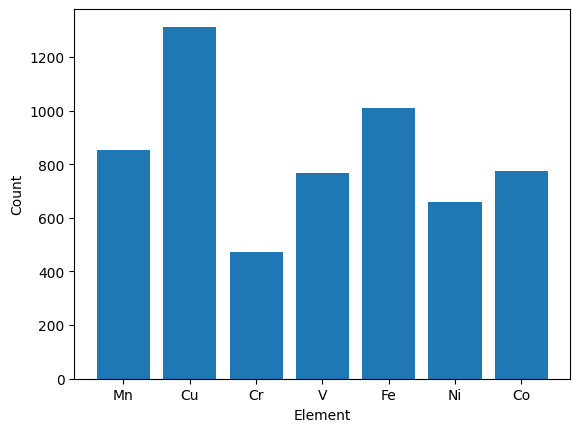

In [18]:
elements = list(data.keys())
counts = list(map(lambda x: len(x), data.values()))
print(sum(counts))
plt.bar(elements, counts)
plt.xlabel('Element')
plt.ylabel('Count')

plt.show()

In [30]:
oxidation_states = [sorted(i['oxidation_state']) for element in data.values() for i in element.values()]

oxidation_state_processed = np.zeros((len(oxidation_states), 8))

for idx, state in enumerate(oxidation_states):
	counter = Counter(state)
	for key, value in counter.items():
		oxidation_state_processed[idx, key] = value

In [37]:
oxidation_state_processed_sum = np.sum(oxidation_state_processed, axis=1).reshape(-1, 1)
oxidation_state_processed = oxidation_state_processed*1/oxidation_state_processed_sum

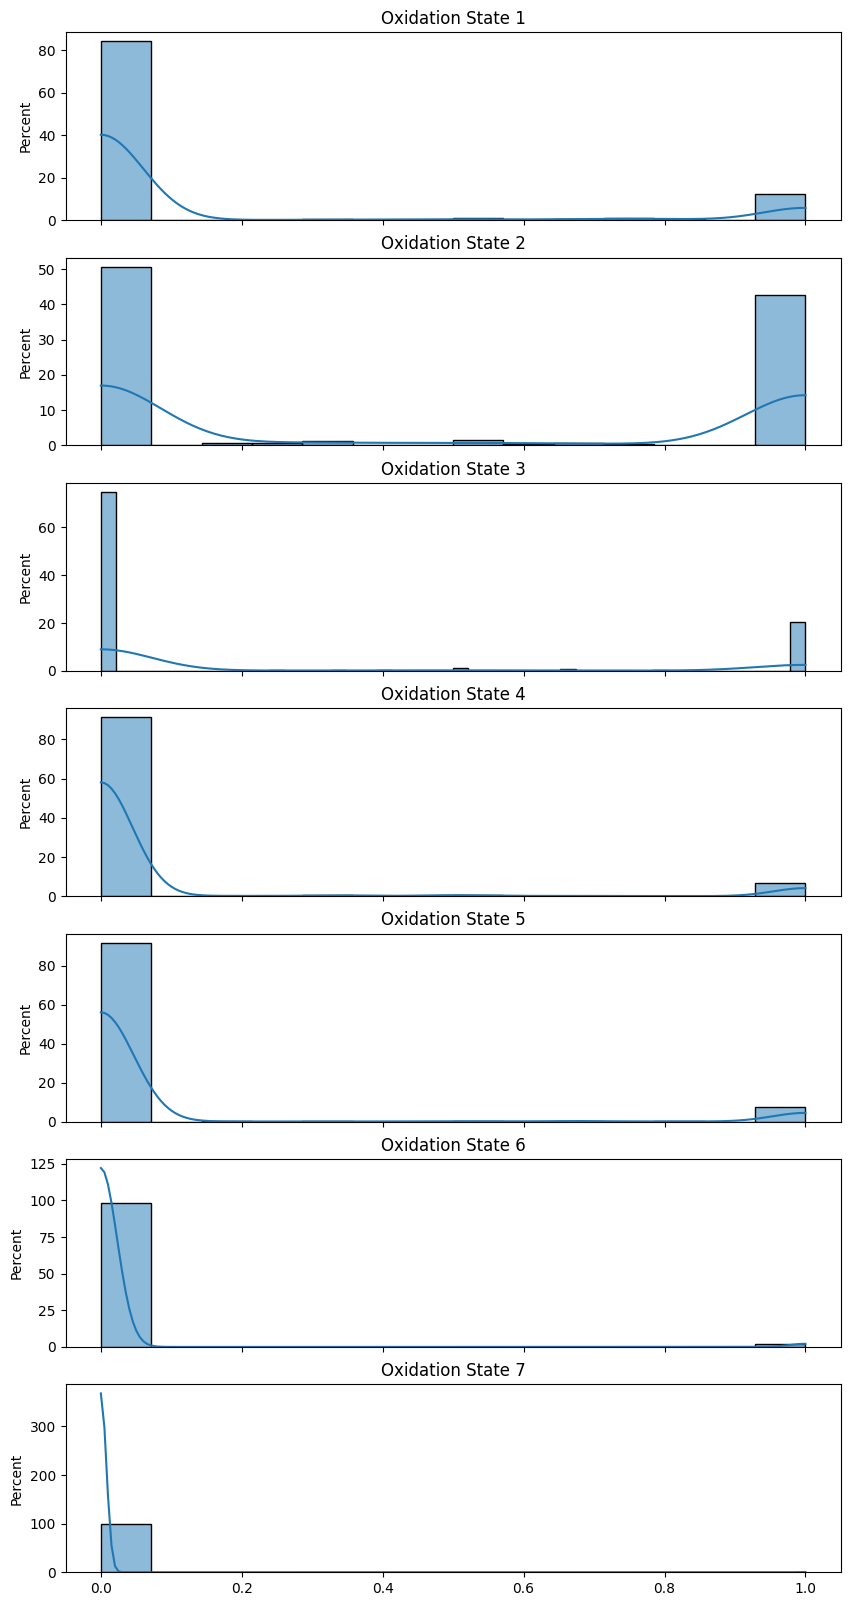

In [54]:
fig, ax = plt.subplots(7, 1, sharex=True, figsize=(10, 20))

for i in range(7):
	j = i+1
	sns.histplot(oxidation_state_processed[:, j], stat = 'percent', ax = ax[i],
				 kde=True)
	ax[i].set_title(f'Oxidation State {j}')

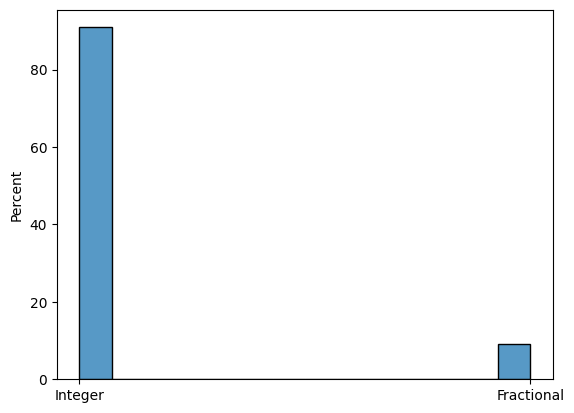

In [62]:
integer_states = oxidation_state_processed != 0
integer_states = np.sum(integer_states, axis = 1)
sns.histplot(integer_states, stat = 'percent')
plt.xticks([1.0, 2.0], ['Integer', 'Fractional'])
plt.show()